# Notebook Intro:

In this notebook, I use my cleaned training data, then look at all the continuous and dummy features that had r2 values over .2 (from notebooks 3a and 3b), import the updated ordinal features and select features that had r2 values over .2 (from notebook 4), and select the discrete features that had r2 values over .2 (from notebook 5).

I address dummies in the training and test data similar to notebook 6.  

I perform a train/test split on the training data, fit a scaler on the train split and then transform both the training and test splits.

I then fit a linear regression, lasso, and ridge to the training split.  And compare the training and test scores for each one, as well as the number of features used. The lasso performs similarly to the other two, but reduces the number of features compared to the other models, so I select this one to continue with.  

I then perform the scaling and fitting of the lasso model to the entire set of training data.  I then use this updated lasso model on the test data to create **prediction 4**.

Finally, since the linear regression is easier to interpret and doesn't have many more features than the lasso model, I also perform the scaling and fitting of the linear regression model to the entire set of training data, and use this updated linear regression model on the test data to create **prediction 5**.

I export the linear regression model of the training data for use in other notebooks.

In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression

In [77]:
# import cleaned training data
filepath = '../datasets/interim_files/train_clean.csv'
df = pd.read_csv(filepath)

#import ordinal features
filepath = '../datasets/interim_files/training_updated_ordinal_features.csv'
df_ord = pd.read_csv(filepath)

In [78]:
# import cleaned test info
filepath = '../datasets/interim_files/test_clean.csv'

testdata = pd.read_csv(filepath)
testdata.head()

# import ordinal features
filepath = '../datasets/interim_files/testdata_updated_ordinal_features.csv'

testdata_ord = pd.read_csv(filepath)

In [79]:
# did manual search for a correlation coeff. greater than .2 in all features

In [80]:
## Based on Step 3 - 

# nominal variables: (based on doing dummy variables for all nominal features)
nom = ['MS SubClass_60', 'MS SubClass_30', 'MS Zoning_RM', 'MS Zoning_RL',
       'Land Contour_HLS', 'Neighborhood_NridgHt', 'Neighborhood_NoRidge',
       'Neighborhood_StoneBr', 'Neighborhood_OldTown', 'House Style_2Story',
       'Roof Style_Hip', 'Roof Style_Gable', 'Exterior 1st_VinylSd',
       'Exterior 2nd_VinylSd', 'Mas Vnr Type_None', 'Mas Vnr Type_Stone',
       'Mas Vnr Type_BrkFace', 'Foundation_PConc', 'Foundation_CBlock',
       'Central Air_Y', 'Garage Type_Detchd', 'Garage Type_Attchd',
       'Garage Type_none', 'Garage Type_BuiltIn'] 

# continuous variables:
cont = ['Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Garage Area',
       'Wood Deck SF', 'Open Porch SF']

In [81]:
# based on step 4
# ordinal variables:
ord = ['Lot Shape', 'Overall Qual', 'Exter Qual', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'Heating QC', 'Electrical',
       'Kitchen Qual', 'Fireplace Qu', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive']

In [82]:
# based on step 5
# discrete variables:
dis = ['Bsmt Full Bath', 'Full Bath', 'Half Bath', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Cars']

## address dummies so training and test have the same

In [83]:
nominal_features = ['MS SubClass','MS Zoning','Street','Alley','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air','Garage Type','Misc Feature']

df_nom = pd.get_dummies(df[nominal_features], columns = nominal_features)
testdata_nom = pd.get_dummies(testdata[nominal_features], columns = nominal_features)

In [84]:
overall_nom = pd.concat([df_nom,testdata_nom], join = 'outer', axis = 0)
overall_nom.head()

,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,...,Misc Feature_Shed,Misc Feature_TenC,Misc Feature_none,Roof Matl_Metal,Roof Matl_Roll,Exterior 1st_PreCast,Exterior 2nd_Other,Exterior 2nd_PreCast,Mas Vnr Type_CBlock,Heating_Floor
0,0,0,0,0,0,1,0,0,0,0,...,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,0,1,0,0,0,0,...,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,0,0,0,0,0,0,0,0,...,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,0,0,1,0,0,0,0,...,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,0,1,0,0,0,0,0,...,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
#separate the training and test data

df_nom_updated = overall_nom[0:2026].fillna(0)
testdata_nom_updated = overall_nom[2026:].fillna(0)

In [86]:
# pull out nominal rows
df_nom_updated2 = df_nom_updated[nom].copy()
testdata_nom_updated2 = testdata_nom_updated[nom].copy()

# Perform prework to modeling

In [87]:
# Create dataframes

X = pd.concat((df[cont], df[dis], df_ord[ord], df_nom_updated2), axis = 1)
y = df['SalePrice']

In [88]:
X.shape

(2026, 55)

In [89]:
y.shape

(2026,)

In [90]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

ss = StandardScaler()
ss.fit(X_train)

X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

# linear regression

In [91]:
lr = LinearRegression()

cross_val_score(lr,X_train, y_train).mean()

0.8142935643056127

In [92]:
lr.fit(X_train, y_train)

LinearRegression()

In [93]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.8498367961363192, 0.8920139068576458)

# lasso

In [94]:
lasso = Lasso()

cross_val_score(lasso,X_train, y_train).mean()

/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1459254405.511963, tolerance: 764817502.7048419
  model = cd_fast.enet_coordinate_descent(


0.8143178140165015

In [95]:
#from kobe-starter
alphas = np.linspace(0.05, 100000, 1000)

In [96]:
lcv = LassoCV(alphas = alphas)
lcv.fit(X_train, y_train)
lcv.score(X_train, y_train), lcv.score(X_test, y_test)

/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76073083974.67358, tolerance: 708342286.5863948
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159970020203.1549, tolerance: 780269701.9526318
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179178929186.7151, tolerance: 764155760.2898041
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jenniferwill

(0.8470174652424732, 0.890223266842744)

In [97]:
max(lcv.alphas_), min(lcv.alphas_)

(100000.0, 0.05)

In [98]:
len(lcv.alphas_)

1000

In [99]:
lcv.alpha_

300.3501501501501

In [100]:
sum(lcv.coef_ != 0)

42

In [101]:
# under45!!!!!

# ridge

In [102]:
ridge = Ridge()

cross_val_score(ridge, X_train, y_train).mean()

0.8145197798083441

In [103]:
alphas = np.linspace(0.01, 10000, 10000)

In [104]:
rcv = RidgeCV(alphas = alphas)
rcv.fit(X_train, y_train)
rcv.score(X_train, y_train), rcv.score(X_test, y_test)

(0.8432345317556331, 0.8880020797822084)

In [105]:
rcv.alpha_

374.0470297029703

In [106]:
rcv.coef_

array([ 2715.86655576,  3722.36787733,  2328.76037913,  2480.10179117,
        5609.33760151,  3765.88129173,  7669.28247861,  4721.98627994,
        1104.04342891,   900.23288656,  2805.36082882,  3677.71762301,
        1477.44947264,  3798.03132725,  3231.33765446,  3708.20967124,
          13.97451626, 10393.37150787,  5918.13107522,  3601.456754  ,
        -848.83292687,  4837.79991625,  2637.78388758,  2772.87553686,
        -224.29486194,  7443.39285029,  3625.77045378,   880.65662064,
         757.91066775,  -102.18406115,  1352.88971263,  1651.52409342,
        -411.92953179, -2257.50298986,   -53.32890291,  3212.75776204,
        7439.58626142,  4741.91741655,  5038.60332216,  -134.87620203,
       -2171.40689587,  2633.19301862, -1334.51456906,   -11.91507664,
        1276.17883496,   925.61874343,  1591.0867719 ,  -607.29946858,
         833.1682429 , -1345.69969975,  1002.06643163,    48.32843254,
        1243.76131526,  2023.1389867 ,   943.56093636])

# redo lassocv so that it covers entire set of training data

In [107]:
# first - recalculate lcv for all of training data
ss2 = StandardScaler()
ss2.fit(X)

X2 = ss2.transform(X)

alphas = np.linspace(0.05, 100000, 1000)

lcv2 = LassoCV(alphas = alphas)
lcv2.fit(X2, y)
lcv2.score(X2, y)

/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19318949335.60791, tolerance: 1019517057.2686168
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6495317675.725342, tolerance: 1025190752.5053548
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164619842910.46826, tolerance: 1004035910.625803
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jenniferw

0.8607365539659744

In [108]:
lcv2.alpha_

200.2501001001001

In [109]:
sum(lcv2.coef_ != 0)

48

In [110]:
# almost 45 (sqrt(2026)) - so stick with this

In [111]:
#fitted attribute
pd.DataFrame({ 
    'var': X.columns,
    'coef val': lcv2.coef_
}).set_index('var').sort_values('coef val', ascending=False).head()

,coef val
var,
Gr Liv Area,16669.577116
Overall Qual,15756.974597
Neighborhood_NridgHt,8515.494157
Kitchen Qual,7669.010817
Exter Qual,6248.691021


# now update test data to lasso

In [112]:
Xtestdata = pd.concat((testdata[cont], testdata[dis], testdata_ord[ord], testdata_nom_updated2), axis = 1)

In [113]:
Xtestdata.fillna(0, inplace = True)

In [114]:
Xtestdata2 = ss2.transform(Xtestdata)

In [115]:
y_pred = lcv2.predict(Xtestdata2)

In [116]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df = y_pred_df.rename(columns={0:'SalePrice'})
y_pred_df.head()

,SalePrice
0,118093.288489
1,167167.432860
2,223760.862469
3,103956.286616
4,175559.192418


In [117]:
final_preds = pd.concat([testdata['Id'],y_pred_df], axis=1 )
final_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         878 non-null    int64  
 1   SalePrice  878 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 13.8 KB


In [118]:
#export predictions
filepath = '../datasets/submissions/prediction4.csv'

final_preds.to_csv(filepath, index=False)

# do one last linear regression because it's easier to interpret.


In [119]:
# first - recalculate lcv for all of training data
X2

alphas = np.linspace(0.05, 100000, 1000)

lr2 = LinearRegression()
lr2.fit(X2, y)
lr2.score(X2, y)

0.8624955201529421

In [120]:
#fitted attribute
fitted_attrs = pd.DataFrame({ 
    'var': X.columns,
    'coef val': lr2.coef_
}).set_index('var').sort_values('coef val', ascending=False)

In [121]:
fitted_attrs

,coef val
var,
Overall Qual,15262.720302
1st Flr SF,11327.145490
Mas Vnr Type_None,11215.680847
Garage Type_none,10896.638472
2nd Flr SF,10552.479318
Neighborhood_NridgHt,8859.031625
Kitchen Qual,7646.243816
Mas Vnr Type_BrkFace,7484.521509
Garage Type_Attchd,6669.769666


In [122]:
#export predictions
filepath = '../datasets/interim_files/manual_lr_fitted_st7.csv'

fitted_attrs.to_csv(filepath)

In [123]:
fitted_attrs.index

Index(['Overall Qual', '1st Flr SF', 'Mas Vnr Type_None', 'Garage Type_none',
       '2nd Flr SF', 'Neighborhood_NridgHt', 'Kitchen Qual',
       'Mas Vnr Type_BrkFace', 'Garage Type_Attchd', 'Neighborhood_StoneBr',
       'Mas Vnr Type_Stone', 'Exterior 2nd_VinylSd', 'Exter Qual',
       'Roof Style_Hip', 'Garage Type_Detchd', 'Bsmt Exposure', 'Garage Qual',
       'Neighborhood_NoRidge', 'Lot Area', 'Mas Vnr Area', 'Garage Cars',
       'Gr Liv Area', 'Land Contour_HLS', 'Bsmt Qual', 'Garage Area',
       'Garage Type_BuiltIn', 'Bsmt Full Bath', 'MS SubClass_60',
       'Fireplace Qu', 'BsmtFin SF 1', 'Heating QC', 'Fireplaces',
       'TotRms AbvGrd', 'BsmtFin Type 1', 'Roof Style_Gable', 'Full Bath',
       'Half Bath', 'Paved Drive', 'Garage Finish', 'Central Air_Y',
       'Wood Deck SF', 'Garage Cond', 'Total Bsmt SF', 'Lot Shape',
       'MS SubClass_30', 'Open Porch SF', 'Neighborhood_OldTown', 'Electrical',
       'Foundation_PConc', 'Foundation_CBlock', 'Bsmt Cond', 'MS Zoni

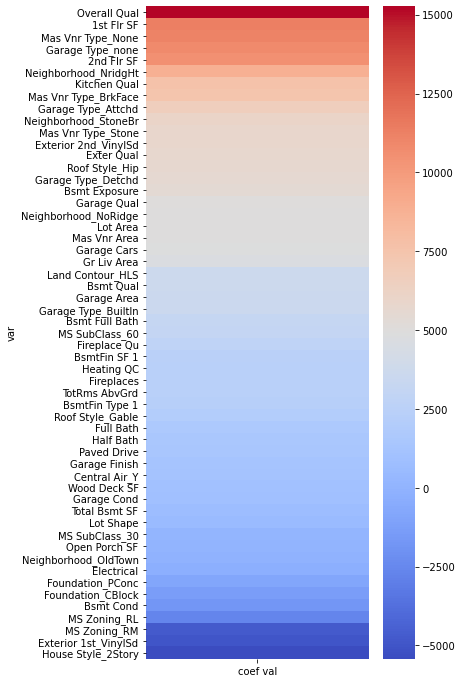

In [124]:
plt.figure(figsize = (5,12))
sns.heatmap(fitted_attrs,
            cmap='coolwarm');

In [125]:
#on test data now - still same scaler

In [126]:
final_preds2 = pd.concat([testdata['Id'],y_pred_df2], axis=1 )
final_preds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         878 non-null    int64  
 1   SalePrice  878 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 13.8 KB


In [127]:
#export predictions
filepath = '../datasets/submissions/prediction5.csv'

final_preds.to_csv(filepath, index=False)

# Notebook Intro:

In this notebook, I use my cleaned training data, then look at all the continuous and dummy features that had r2 values over .2 (from notebooks 3a and 3b), import the updated ordinal features and select features that had r2 values over .2 (from notebook 4), and select the discrete features that had r2 values over .2 (from notebook 5).

I address dummies in the training and test data similar to notebook 6.  

I perform a train/test split on the training data, fit a scaler on the train split and then transform both the training and test splits.

I then fit a linear regression, lasso, and ridge to the training split.  And compare the training and test scores for each one, as well as the number of features used. The lasso performs similarly to the other two, but reduces the number of features compared to the other models, so I select this one to continue with.  

I then perform the scaling and fitting of the lasso model to the entire set of training data.  I then use this updated lasso model on the test data to create **prediction 4**.

Finally, since the linear regression is easier to interpret and doesn't have many more features than the lasso model, I also perform the scaling and fitting of the linear regression model to the entire set of training data, and use this updated linear regression model on the test data to create **prediction 5**.

I export the linear regression model of the training data for use in other notebooks.